# Speed Dating A→B→C Loop — Minimal Notebook

This notebook trains two small models on the Speed Dating dataset:
- **f1 (A→B)**: predict whether A says *yes* to B
- **f2 (B→C)**: predict whether B says *yes* to C (role-swapped view)

Then it demos the **A→B→C loop** and reports a simple two-hop metric.

**Instructions**
1. Ensure you have a CSV with one row per date (A with B), including:
   - `iid` (A's id), `pid` (B's id), `dec` (A's yes=1/no=0). Adjust names below if needed.
2. Install requirements in your environment: `pip install -r requirements.txt` (see provided file).
3. Run all cells. Edit `DATA_CSV`, `ID_COL`, `PARTNER_COL`, `DECISION_COL` as needed.

In [12]:
# --- Config: point to your CSV and columns ---
DATA_CSV = "speeddating.csv"  # <-- CHANGE ME
ID_COL = "aid"            # person A id column
PARTNER_COL = "bid"       # person B id column
DECISION_COL = "decision"      # A's decision about B (1 yes, 0 no)
SEED = 42
K = 10                     # for Precision@K and loop Top-K

# Optionally, specify explicit features (comma-separated list). If None, auto-select numerics
FEATURE_COLS = None  # e.g., ["attr", "fun", "intel", "amb"]

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier

In [14]:
# --- Load CSV ---
path = Path(DATA_CSV)
assert path.exists(), f"CSV not found at: {path}"
df = pd.read_csv(path)
# df[DECISION_COL] = df[DECISION_COL].astype(int)
print(df.shape)
df.head(3)

(8378, 123)


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,b'[0-3]',b'[3-5]',7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1'


In [15]:
# === CLEANING CELL: decode bytes, normalize strings, fix missing, coerce numerics ===
import re
import pandas as pd
import numpy as np

df_raw = df.copy(deep=True)  # keep an untouched copy for comparison

def _decode_bytes_cell(x):
    """Convert byte-literal looking values to clean text; leave non-strings unchanged."""
    if isinstance(x, bytes):
        try:
            return x.decode("utf-8").strip()
        except Exception:
            return str(x).strip()
    if isinstance(x, str):
        s = x.strip()
        # strip python-style byte literal wrappers: b'...' or b"..."
        if (s.startswith("b'") and s.endswith("'")) or (s.startswith('b"') and s.endswith('"')):
            s = s[2:-1].strip()
        return s
    return x

# 1) Decode byte-literal wrappers and trim whitespace on object columns
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].apply(_decode_bytes_cell)

# 2) Normalize categorical strings: lowercase; keep bracketed ranges as-is (e.g., "[6-8]")
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].apply(lambda v: v.lower().strip() if isinstance(v, str) else v)

# 3) Unify missing value markers
MISSING_MARKERS = {"", "na", "n/a", "none", "null", "nan", "(missing)"}
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].replace(list(MISSING_MARKERS), pd.NA)

# 4) Coerce numeric-looking columns to numbers.
#    We DO NOT coerce bracketed ranges like "[6-8]" (keep those as categorical).
_bracket_re = re.compile(r"^\[.*\]$")
def _is_numeric_series(s: pd.Series, sample=200):
    """Heuristic: if most non-null values parse as numbers and few are bracketed ranges, treat numeric."""
    non_null = s.dropna()
    if non_null.empty:
        return False
    sample_vals = non_null.sample(min(sample, len(non_null)), random_state=42)
    # ignore bracketed ranges
    if any(isinstance(v, str) and _bracket_re.match(v) for v in sample_vals):
        return False
    # try to coerce a sample
    ok = 0
    for v in sample_vals:
        if isinstance(v, (int, float, np.integer, np.floating)):
            ok += 1
        elif isinstance(v, str):
            try:
                float(v)
                ok += 1
            except Exception:
                pass
    return ok / len(sample_vals) >= 0.8

numeric_coerced = []
for c in df.columns:
    if df[c].dtype == object and _is_numeric_series(df[c]):
        df[c] = pd.to_numeric(df[c], errors="coerce")  # becomes float; unparseable -> NaN
        numeric_coerced.append(c)

# 5) Optional: create partner gender (opposite of A's gender) if you have 'gender' text
if "gender" in df.columns and df["gender"].dtype == object:
    # Normalize a few possible encodings
    _male_vals = {"male", "m", "1", "1.0"}
    _female_vals = {"female", "f", "0", "0.0"}
    def _norm_gender(g):
        if pd.isna(g): return pd.NA
        g = str(g).lower().strip()
        if g in _male_vals: return "male"
        if g in _female_vals: return "female"
        return g  # leave as-is if unknown
    df["gender"] = df["gender"].apply(_norm_gender)
    if "gender_o" not in df.columns:
        df["gender_o"] = df["gender"].apply(lambda g: "female" if g == "male" else ("male" if g == "female" else pd.NA))

# 6) Quick summary
print("=== Cleaning summary ===")
print(f"Rows: {len(df):,}  Cols: {df.shape[1]}")
print(f"Numeric columns coerced: {len(numeric_coerced)}")
print("First 10 coerced columns:", numeric_coerced[:10])
print("\nDtypes (first 20):")
print(df.dtypes.head(20))


=== Cleaning summary ===
Rows: 8,378  Cols: 124
Numeric columns coerced: 4
First 10 coerced columns: ['samerace', 'decision', 'decision_o', 'match']

Dtypes (first 20):
has_null                       object
wave                          float64
gender                         object
age                           float64
age_o                         float64
d_age                         float64
d_d_age                        object
race                           object
race_o                         object
samerace                        int64
importance_same_race          float64
importance_same_religion      float64
d_importance_same_race         object
d_importance_same_religion     object
field                          object
pref_o_attractive             float64
pref_o_sincere                float64
pref_o_intelligence           float64
pref_o_funny                  float64
pref_o_ambitious              float64
dtype: object


In [16]:
# Opposite gender for partner side (if not already present)
if "gender_o" not in df.columns:
    df["gender_o"] = df["gender"].apply(lambda g: "female" if g == "male" else ("male" if g == "female" else pd.NA))

# A/B base columns (keep A minimal to avoid per-date noise)
A_base_cols = [c for c in ["wave","gender","age","race","field"] if c in df.columns]
B_base_cols = [c for c in ["wave","gender_o","age_o","race_o",
                           "pref_o_attractive","pref_o_sincere","pref_o_intelligence",
                           "pref_o_funny","pref_o_ambitious","pref_o_shared_interests"] if c in df.columns]

def make_id(df_sub, cols, name):
    sig = df_sub[cols].astype(str).agg("|".join, axis=1)
    codes, _ = pd.factorize(sig, sort=True)
    return pd.Series(codes, index=df_sub.index, name=name)

df["aid"] = make_id(df, A_base_cols, "aid")
df["bid"] = make_id(df, B_base_cols, "bid")

print("Unique A IDs:", df["aid"].nunique())
print("Unique B IDs:", df["bid"].nunique())
print("Rows per A (min/median/max):", df.groupby("aid").size().agg(["min","median","max"]).to_dict())
print("Rows per B (min/median/max):", df.groupby("bid").size().agg(["min","median","max"]).to_dict())


Unique A IDs: 537
Unique B IDs: 550
Rows per A (min/median/max): {'min': 5.0, 'median': 16.0, 'max': 44.0}
Rows per B (min/median/max): {'min': 5.0, 'median': 16.0, 'max': 22.0}


# HBG Training

In [17]:
# === PRODUCT-SAFE TRAINING: A→B using only pre-date features ===
# - A-side: demographics, A's partner ideals (*_important), A's self-ratings, A interests
# - B-side: demographics *_o, B self-ratings *_o (if present), and B partner preferences pref_o_*
# - Interactions: simple, computable pre-date (samerace, d_age, interests_correlate if available)
# - No post-date signals (like/guess_prob_liked/met/decision_o/match), no *_partner columns

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

SEED = 42
ID_COL, PARTNER_COL, DECISION_COL = "aid", "bid", "decision"

def exists(c): return c in df.columns
def pick_first(*alts):
    for a in alts:
        if a and exists(a): return a
    return None

# --- A-side (self + what A looks for in a partner) ---
A_features = [c for c in [
    "gender","age","race","field",
    "attractive_important","sincere_important","intellicence_important",
    "funny_important","ambtition_important","shared_interests_important",
    "attractive","sincere","intelligence","funny","ambition",
    # Interests (use the ones you actually have)
    "sports","tvsports","exercise","dining","museums","art","hiking","gaming",
    "clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga"
] if exists(c)]

# --- B-side demographics (partner) ---
B_demo = [c for c in ["gender_o","age_o","race_o","field_o"] if exists(c)]

# --- B-side self-ratings (optional; keep if present) ---
B_self = [c for c in [
    "attractive_o", pick_first("sincere_o","sinsere_o"),
    "intelligence_o","funny_o", pick_first("ambitous_o","ambitious_o"),
    "shared_interests_o"
] if c]

# --- B-side partner preferences (REQUESTED): what B says they want in a partner ---
B_pref_partner = [c for c in [
    "pref_o_attractive","pref_o_sincere","pref_o_intelligence",
    "pref_o_funny","pref_o_ambitious","pref_o_shared_interests"
] if exists(c)]

# --- Interactions computable pre-date ---
Interactions = [c for c in [
    "samerace",                    # simple equality of race
    "d_age",                       # age difference (can compute if missing)
    "interests_correlate",         # if present
    "importance_same_race","importance_same_religion"
] if exists(c)]

# If d_age not present, compute it once
if not exists("d_age") and all(exists(c) for c in ["age","age_o"]):
    df["d_age"] = df["age"] - df["age_o"]
    Interactions.append("d_age")

# Ensure 'samerace' exists if you want it
if not exists("samerace") and all(exists(c) for c in ["race","race_o"]):
    df["samerace"] = (df["race"].astype(str) == df["race_o"].astype(str)).astype(int)
    if "samerace" not in Interactions:
        Interactions.append("samerace")

SAFE_FEATURES = A_features + B_demo + B_self + B_pref_partner + Interactions
SAFE_FEATURES = [c for c in SAFE_FEATURES if exists(c)]
SAFE_FEATURES = list(dict.fromkeys(SAFE_FEATURES))  # de-dup, keep order

print(f"Using {len(SAFE_FEATURES)} product-safe features:")
print(SAFE_FEATURES)

# --- Leakage-free participant split (by A person) ---
people = df[ID_COL].unique()
train_ids, temp_ids = train_test_split(people, test_size=0.30, random_state=SEED, shuffle=True)
val_ids,   test_ids = train_test_split(temp_ids, test_size=0.50, random_state=SEED, shuffle=True)

def slice_by_ids(d, ids):
    return d[d[ID_COL].isin(ids)].copy()

tr = slice_by_ids(df, train_ids)
va = slice_by_ids(df, val_ids)
te = slice_by_ids(df, test_ids)

Xtr, ytr = tr[SAFE_FEATURES], tr[DECISION_COL].astype(int).values
Xva, yva = va[SAFE_FEATURES], va[DECISION_COL].astype(int).values
Xte, yte = te[SAFE_FEATURES], te[DECISION_COL].astype(int).values

# --- Preprocess: one-hot categoricals, passthrough numerics ---
cat_cols = Xtr.select_dtypes(include="object").columns.tolist()
num_cols = Xtr.select_dtypes(include=["float64","int64","int32","float32"]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

# --- Model + calibration ---
hgb = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=600, random_state=SEED)
pipe_ab = Pipeline([("pre", pre), ("clf", hgb)])

pipe_ab.fit(Xtr, ytr)
cal_ab = CalibratedClassifierCV(pipe_ab, method="isotonic", cv="prefit")
cal_ab.fit(Xva, yva)

# --- Evaluate on test (clean, product-safe) ---
proba = cal_ab.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics_clean = {
    "accuracy": float(accuracy_score(yte, pred)),
    "precision": float(precision_score(yte, pred, zero_division=0)),
    "recall": float(recall_score(yte, pred, zero_division=0)),
    "f1": float(f1_score(yte, pred, zero_division=0)),
}
try:
    metrics_clean["roc_auc"] = float(roc_auc_score(yte, proba))
except Exception:
    metrics_clean["roc_auc"] = float("nan")

print("\nClean product-safe A→B metrics:")
print(metrics_clean)


Using 52 product-safe features:
['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'gender_o', 'age_o', 'race_o', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'samerace', 'd_age', 'interests_correlate', 'importance_same_race', 'importance_same_religion']

Clean product-safe A→B metrics:
{'accuracy': 0.6151832460732984, 'precision': 0.5185185185185185, 'recall': 0.49015317286652077, 'f1': 0.5039370078740157, 'roc_auc': 0.6435499391818289}


/Users/alvin/Programming/School/4AL3/4AL3-Project/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


# XGBoost Training

In [18]:
# === Retrain A→B using XGBoost ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

SEED = 42
ID_COL, DECISION_COL = "aid", "decision"

# --- Use the same SAFE_FEATURES from before (with engineered cols if present)
Xtr, ytr = tr[SAFE_FEATURES], tr[DECISION_COL].astype(int).values
Xva, yva = va[SAFE_FEATURES], va[DECISION_COL].astype(int).values
Xte, yte = te[SAFE_FEATURES], te[DECISION_COL].astype(int).values

cat_cols = Xtr.select_dtypes(include="object").columns.tolist()
num_cols = Xtr.select_dtypes(include=["float64","int64","int32","float32"]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators=600,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=SEED,
    n_jobs=-1,
)

pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])
pipe_xgb.fit(Xtr, ytr)

# --- Calibrate (optional but helps for probabilities)
cal_xgb = CalibratedClassifierCV(pipe_xgb, method="isotonic", cv="prefit")
cal_xgb.fit(Xva, yva)

# --- Evaluate
proba = cal_xgb.predict_proba(Xte)[:,1]
pred  = (proba >= 0.5).astype(int)

metrics_xgb = {
    "accuracy": float(accuracy_score(yte, pred)),
    "precision": float(precision_score(yte, pred, zero_division=0)),
    "recall": float(recall_score(yte, pred, zero_division=0)),
    "f1": float(f1_score(yte, pred, zero_division=0)),
}
try:
    metrics_xgb["roc_auc"] = float(roc_auc_score(yte, proba))
except Exception:
    metrics_xgb["roc_auc"] = float("nan")

print("\nXGBoost A→B metrics:")
print(metrics_xgb)



XGBoost A→B metrics:
{'accuracy': 0.6326352530541012, 'precision': 0.5454545454545454, 'recall': 0.4726477024070022, 'f1': 0.5064478311840562, 'roc_auc': 0.6561137347438492}


/Users/alvin/Programming/School/4AL3/4AL3-Project/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [19]:
# === Build person-level profile tables for A and B sides, then unify ===

# Choose person attributes you want in a profile (survey-available only)
BASE_COLS = [c for c in [
    "gender", "age", "race", "field",
    "attractive_important", "sincere_important", "intellicence_important",
    "funny_important", "ambtition_important", "shared_interests_important",
    "attractive", "sincere", "intelligence", "funny", "ambition",
    "sports","music","movies","reading","exercise","hiking","art","shopping"
] if c in df.columns]

# Map B-side columns (_o typos handled) to the same base schema
def pick_first(*alts):
    for a in alts:
        if a in df.columns: return a
    return None

# A-side profiles
profiles_A = (
    df.groupby("aid")[["aid"] + BASE_COLS]
      .agg("first")
      .rename_axis("person_id")
      .reset_index(drop=True)
)
profiles_A = profiles_A.rename(columns={"aid": "source_id"})

# unify to the same columns (missing become NaN)
PROFILE_COLS = sorted(set(BASE_COLS))
profiles_A = profiles_A.reindex(columns=["source_id"] + PROFILE_COLS)

profiles = pd.concat([profiles_A], ignore_index=True)

# Basic consistency
profiles = profiles.dropna(subset=["gender"])  # must know gender
profiles["gender"] = profiles["gender"].astype(str)

print("Profiles:", profiles.shape)
profiles.head(3)
print(profiles.columns.tolist())


Profiles: (537, 24)
['source_id', 'age', 'ambition', 'ambtition_important', 'art', 'attractive', 'attractive_important', 'exercise', 'field', 'funny', 'funny_important', 'gender', 'hiking', 'intellicence_important', 'intelligence', 'movies', 'music', 'race', 'reading', 'shared_interests_important', 'shopping', 'sincere', 'sincere_important', 'sports']


In [20]:
import numpy as np
import pandas as pd

CAL_MODEL = cal_xgb  # <- change this if your calibrated model has a different name

# Map B's base fields -> model's partner columns
BASE_TO_O = {
    "gender":"gender_o","age":"age_o","race":"race_o","field":"field_o",
    "attractive":"attractive_o","sincere":"sinsere_o","intelligence":"intelligence_o",
    "funny":"funny_o","ambition":"ambitous_o","shared_interests":"shared_interests_o",
}

def assemble_pairs_for_model(A_profile: pd.Series,
                             B_table: pd.DataFrame,
                             feature_cols: list) -> pd.DataFrame:
    """Build the exact columns the model expects for (A,B) pairs."""
    rows = []
    for _, b in B_table.iterrows():
        r = {}

        # A-side: copy A_profile into any A feature the model expects
        for c in profiles.columns:
            if c in feature_cols and c in A_profile.index and c != "source_id":
                r[c] = A_profile[c]

        # B-side: copy B base fields into *_o columns the model expects
        for base, ocol in BASE_TO_O.items():
            if ocol in feature_cols and base in b.index:
                r[ocol] = b[base]

        # Interactions we can compute safely (only if model expects them)
        if "samerace" in feature_cols:
            r["samerace"] = int(A_profile.get("race") == b.get("race"))
        if "d_age" in feature_cols:
            try:
                r["d_age"] = float(A_profile.get("age")) - float(b.get("age"))
            except Exception:
                r["d_age"] = np.nan
        # If you engineered others like interest_similarity/pref_alignment_score,
        # leave them NaN here unless you compute them from survey values.
        rows.append(r)

    Xpairs = pd.DataFrame(rows).reindex(columns=feature_cols)
    return Xpairs

def recommend_topk_for_A(A_profile: pd.Series,
                         profiles_df: pd.DataFrame,
                         feature_cols: list,
                         k: int = 10):
    """Score A vs all opposite gender, return Top-K table with useful columns."""
    a_gender = str(A_profile["gender"]).lower()
    opp_gender = "female" if a_gender == "male" else "male"

    B_cands = profiles_df[profiles_df["gender"].str.lower() == opp_gender].copy()
    Xpairs = assemble_pairs_for_model(A_profile, B_cands, feature_cols)
    scores = CAL_MODEL.predict_proba(Xpairs)[:, 1]

    out = B_cands.copy()
    out["p_AB"] = scores

    # Choose a compact set of columns to display (show only those that exist)
    show_cols = ["source_id","gender","age","race","field",
                 "attractive","sincere","intelligence","funny","ambition",
                 "sports","music","movies","reading","exercise"]
    show_cols = [c for c in show_cols if c in out.columns]

    topk = out.sort_values("p_AB", ascending=False).head(k)
    return topk[show_cols + ["p_AB"]]


In [21]:
# ----- Example A built from survey inputs (edit values to test) -----
survey_A = {
    "gender":"male","age":21,"race":"asian/pacific islander/asian-american","field":"economics",
    "attractive_important":30,"sincere_important":15,"intellicence_important":10,
    "funny_important":15,"ambtition_important":15,"shared_interests_important":15,
    "attractive":8,"sincere":9,"intelligence":8,"funny":8,"ambition":9,
    "sports":3,"music":4,"movies":8,"reading":5,"exercise":9,"hiking":7,"art":3,"shopping":7,
}
A_profile = pd.Series({c: survey_A.get(c, np.nan) for c in profiles.columns if c!="source_id"})

# If you prefer to pick an existing person instead:
# A_profile = profiles.loc[profiles["source_id"] == SOME_ID].iloc[0]

topB = recommend_topk_for_A(A_profile, profiles, SAFE_FEATURES, k=10)
topB.reset_index(drop=True)


,source_id,gender,age,race,field,attractive,sincere,intelligence,funny,ambition,sports,music,movies,reading,exercise,p_AB
0,137,female,29.0,other,music education,9.0,10.0,9.0,9.0,8.0,8.0,10.0,9.0,5.0,10.0,0.642241
1,439,female,27.0,european/caucasian-american,finance,8.0,10.0,10.0,9.0,10.0,7.0,10.0,10.0,5.0,10.0,0.642241
2,367,female,26.0,latino/hispanic american,law,9.0,9.0,9.0,9.0,9.0,8.0,9.0,9.0,7.0,7.0,0.642241
3,199,female,29.0,european/caucasian-american,psychology,7.0,8.0,4.0,8.0,8.0,6.0,6.0,7.0,7.0,4.0,0.642241
4,198,female,28.0,european/caucasian-american,social work,9.0,8.0,5.0,9.0,3.0,6.0,6.0,9.0,9.0,5.0,0.642241
5,369,female,28.0,european/caucasian-american,german literature,7.0,10.0,7.0,10.0,7.0,1.0,10.0,10.0,10.0,5.0,0.642241
6,370,female,29.0,other,psychology,7.0,9.0,9.0,9.0,9.0,3.0,9.0,7.0,5.0,9.0,0.642241
7,194,female,22.0,european/caucasian-american,social work,8.0,9.0,7.0,10.0,7.0,8.0,5.0,7.0,9.0,5.0,0.642241
8,382,female,22.0,european/caucasian-american,communications,7.0,9.0,9.0,9.0,4.0,2.0,10.0,10.0,4.0,1.0,0.642241
9,383,female,22.0,european/caucasian-american,social work,6.0,8.0,8.0,8.0,8.0,7.0,10.0,8.0,6.0,10.0,0.642241


In [22]:
def weighted_composite(df_top: pd.DataFrame, weight_col: str,
                       numeric_cols: list, categorical_cols: list) -> pd.Series:
    import numpy as np
    import pandas as pd

    if df_top.empty:
        return pd.Series(dtype=float)

    # weights aligned to df_top index
    w = pd.to_numeric(df_top[weight_col], errors="coerce")
    w = pd.Series(w, index=df_top.index).fillna(0.0)
    if w.sum() <= 0:
        w[:] = 1.0
    w = w / w.sum()

    out = {}

    # numeric: weighted mean
    for c in numeric_cols:
        if c in df_top.columns:
            x = pd.to_numeric(df_top[c], errors="coerce")
            out[c] = float((x * w).sum(skipna=True))

    # categorical: weighted mode (sum weights per category)
    for c in categorical_cols:
        if c in df_top.columns:
            vals = df_top[c].astype(str).fillna("nan")
            # group weights by category label directly
            scores = w.groupby(vals).sum()
            # take the category with the highest total weight
            out[c] = scores.sort_values(ascending=False).index[0]

    return pd.Series(out)


# Choose which profile fields to blend
numeric_for_composite = [c for c in [
    "age",
    "attractive_important","sincere_important","intellicence_important",
    "funny_important","ambtition_important","shared_interests_important",
    "attractive","sincere","intelligence","funny","ambition",
    "sports","music","movies","reading","exercise","hiking","art","shopping"
] if c in profiles.columns]
categorical_for_composite = [c for c in ["gender","race","field"] if c in profiles.columns]

# Build B* from topB (weights = p_AB)
B_star = weighted_composite(
    topB,                     # not topB.join(...)
    "p_AB",
    numeric_for_composite,
    categorical_for_composite
)
# Ensure B* gender is opposite of A
B_star["gender"] = "female" if str(A_profile["gender"]).lower()=="male" else "male"

# Now score B* against same-gender-as-A candidates to get top C
same_as_A = str(A_profile["gender"]).lower()
C_cands = profiles[profiles["gender"].str.lower() == same_as_A].copy()

Xpairs_BC = assemble_pairs_for_model(B_star, C_cands, SAFE_FEATURES)
p_BC = CAL_MODEL.predict_proba(Xpairs_BC)[:, 1]
topC = C_cands.assign(p_BC=p_BC).sort_values("p_BC", ascending=False).head(10)

showC = ["source_id","gender","age","race","field","ambtition_important","p_BC"]
showC = [c for c in showC if c in topC.columns] + ["p_BC"]
topC_table = topC[showC].reset_index(drop=True)

print("Top-10 B for A")
display(topB.reset_index(drop=True))
print("\nComposite B* (preview):")
display(B_star.to_frame(name="value"))
print("\nTop-10 C for B* (same gender as A)")
display(topC_table)

# Optional save
topC_table.to_csv("top10_C_for_Bstar.csv", index=False)
print("Saved: top10_C_for_Bstar.csv")


Top-10 B for A


,source_id,gender,age,race,field,attractive,sincere,intelligence,funny,ambition,sports,music,movies,reading,exercise,p_AB
0,137,female,29.0,other,music education,9.0,10.0,9.0,9.0,8.0,8.0,10.0,9.0,5.0,10.0,0.642241
1,439,female,27.0,european/caucasian-american,finance,8.0,10.0,10.0,9.0,10.0,7.0,10.0,10.0,5.0,10.0,0.642241
2,367,female,26.0,latino/hispanic american,law,9.0,9.0,9.0,9.0,9.0,8.0,9.0,9.0,7.0,7.0,0.642241
3,199,female,29.0,european/caucasian-american,psychology,7.0,8.0,4.0,8.0,8.0,6.0,6.0,7.0,7.0,4.0,0.642241
4,198,female,28.0,european/caucasian-american,social work,9.0,8.0,5.0,9.0,3.0,6.0,6.0,9.0,9.0,5.0,0.642241
5,369,female,28.0,european/caucasian-american,german literature,7.0,10.0,7.0,10.0,7.0,1.0,10.0,10.0,10.0,5.0,0.642241
6,370,female,29.0,other,psychology,7.0,9.0,9.0,9.0,9.0,3.0,9.0,7.0,5.0,9.0,0.642241
7,194,female,22.0,european/caucasian-american,social work,8.0,9.0,7.0,10.0,7.0,8.0,5.0,7.0,9.0,5.0,0.642241
8,382,female,22.0,european/caucasian-american,communications,7.0,9.0,9.0,9.0,4.0,2.0,10.0,10.0,4.0,1.0,0.642241
9,383,female,22.0,european/caucasian-american,social work,6.0,8.0,8.0,8.0,8.0,7.0,10.0,8.0,6.0,10.0,0.642241



Composite B* (preview):


,value
age,26.2
attractive,7.7
sincere,9.0
intelligence,7.7
funny,9.0
ambition,7.3
sports,5.6
music,8.5
movies,8.6
reading,6.7



Top-10 C for B* (same gender as A)


,source_id,gender,age,race,field,ambtition_important,p_BC,p_BC
0,380,male,28.0,european/caucasian-american,mba,0.00,0.642241,0.642241
1,527,male,27.0,european/caucasian-american,mathematics; phd,4.76,0.642241,0.642241
2,66,male,25.0,european/caucasian-american,genetics & development,0.00,0.642241,0.642241
3,264,male,29.0,european/caucasian-american,film,10.00,0.642241,0.642241
4,474,male,28.0,european/caucasian-american,physics,11.36,0.642241,0.642241
5,408,male,27.0,asian/pacific islander/asian-american,business,10.00,0.642241,0.642241
6,225,male,27.0,asian/pacific islander/asian-american,law,0.00,0.642241,0.642241
7,495,male,27.0,other,law and social work,16.98,0.642241,0.642241
8,306,male,30.0,european/caucasian-american,finance&economics,5.00,0.589862,0.589862
9,317,male,26.0,asian/pacific islander/asian-american,electrical engineering,0.00,0.589862,0.589862


Saved: top10_C_for_Bstar.csv


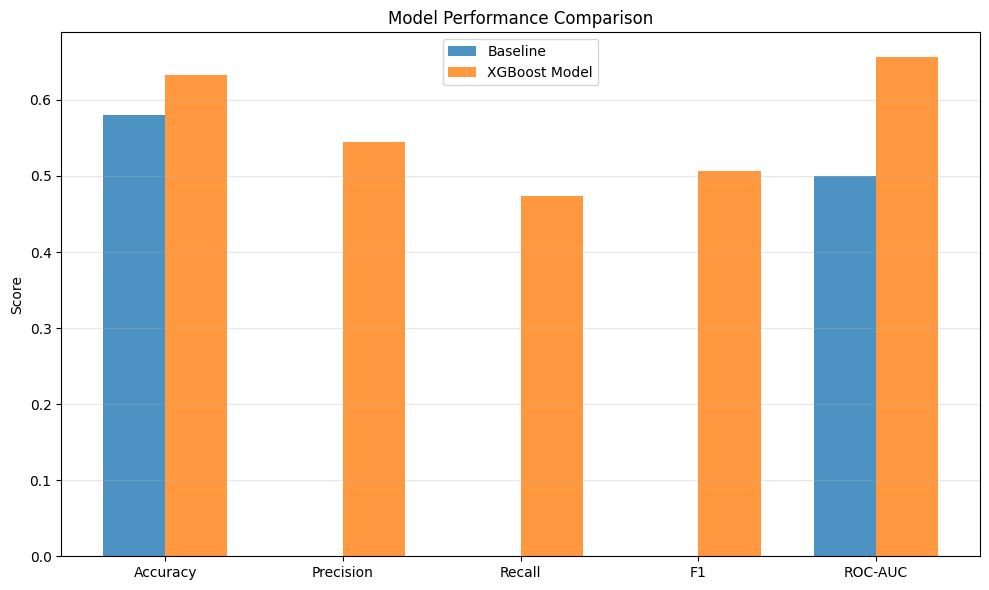

In [27]:
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
baseline = [0.58, 0, 0, 0, 0.5]  # majority class baseline
xgboost_scores = [0.633, 0.545, 0.473, 0.506, 0.656]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, baseline, width, label='Baseline', alpha=0.8)
ax.bar(x + width/2, xgboost_scores, width, label='XGBoost Model', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

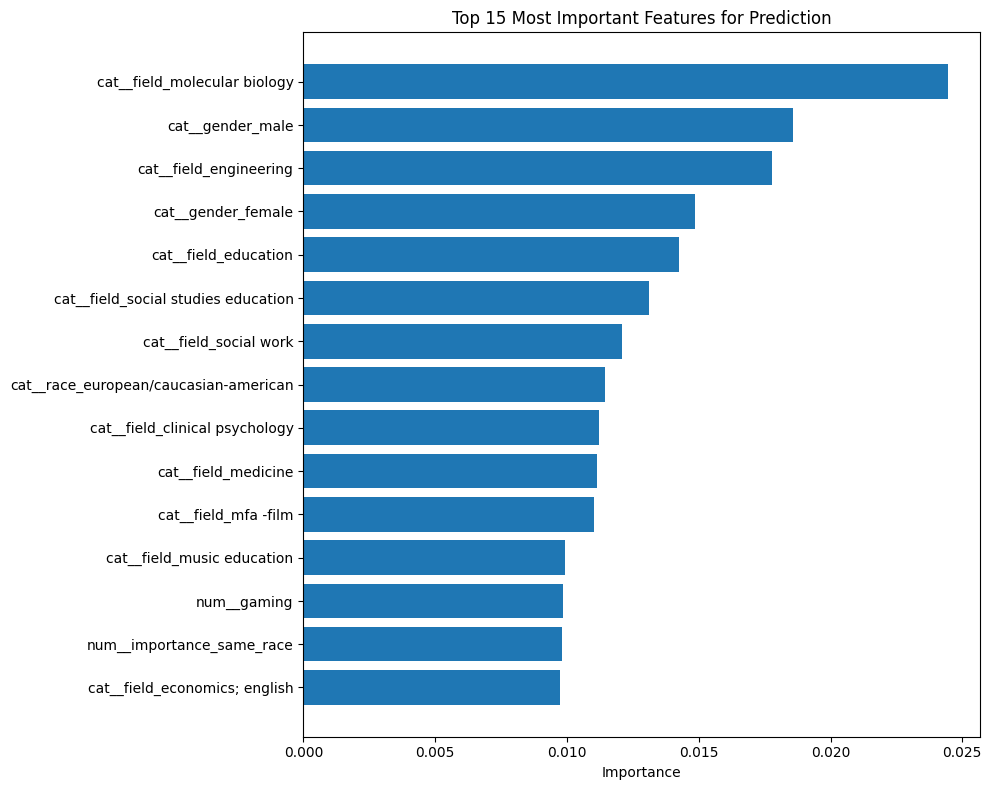

In [28]:
import xgboost as xgb

# Get feature importance from the trained model
model = cal_xgb.calibrated_classifiers_[0].estimator.named_steps['clf']
feature_names = cal_xgb.calibrated_classifiers_[0].estimator.named_steps['pre'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features for Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

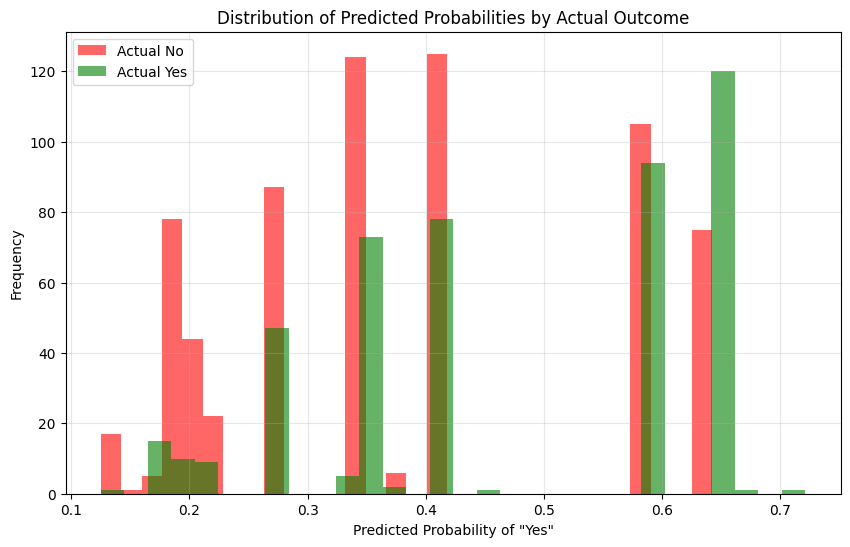

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(proba[yte==0], bins=30, alpha=0.6, label='Actual No', color='red')
plt.hist(proba[yte==1], bins=30, alpha=0.6, label='Actual Yes', color='green')
plt.xlabel('Predicted Probability of "Yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities by Actual Outcome')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout

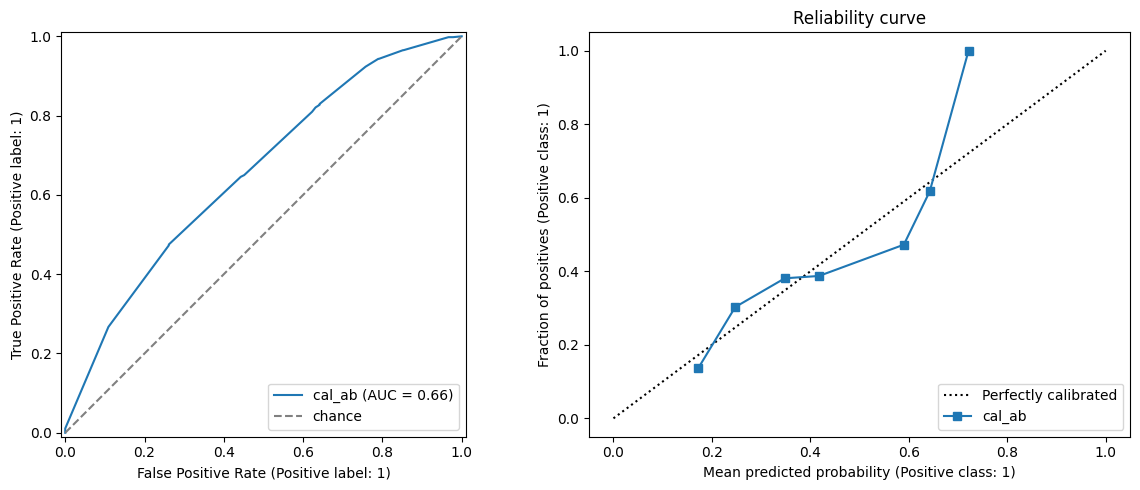

In [35]:
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(yte, proba, ax=ax[0], name="cal_ab")
ax[0].plot([0, 1], [0, 1], "--", color="gray", label="chance")
ax[0].legend(loc="lower right")

CalibrationDisplay.from_predictions(yte, proba, n_bins=10, ax=ax[1], name="cal_ab")
ax[1].set_title("Reliability curve")

plt.tight_layout()
plt.show()